In [1]:
import sys         
sys.path.append('./../src/') 
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from data.load_data import load_ptbxl_data
from signals.ecg import ECGSignal
from biosppy.signals.ecg import ecg

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../data/ptbxl")

%load_ext autoreload
%autoreload 2

In [2]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=100,
    path = DATASET_PATH,
    target = TARGET
)

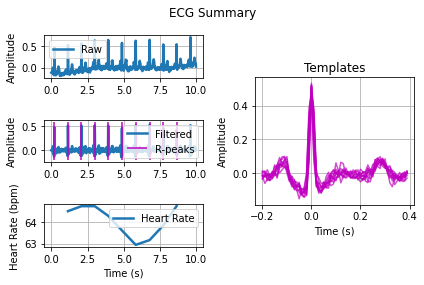

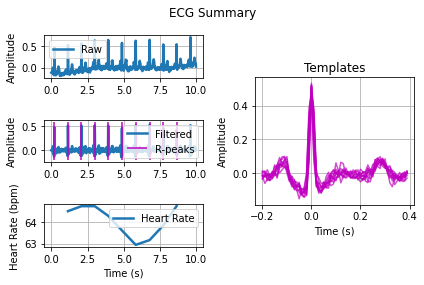

In [3]:
ecg_data = ptbxl_data['train']['X'][0, :, 0]
ecg_sig = ECGSignal("ECG", ecg_data, 100)
ecg_info = ecg(ecg_data, 100)

In [24]:
from signals.utils import parse_nested_feats
import pandas as pd
from tqdm.auto import tqdm

In [21]:
nested_feats = ecg_sig.extract_features()
feats = parse_nested_feats(nested_feats)

In [71]:
from joblib import Parallel, delayed

def get_feats_for_all_channels(ecg_data):
    try:
        feats = {}
        for i, ecg_channel in enumerate(ecg_data.T):
            ecg_channel_sig = ECGSignal(f"ecg_{i}", ecg_channel, 100)
            feats[ecg_channel_sig.name] = ecg_channel_sig.extract_features()
        feats = parse_nested_feats(feats)
        return feats
    except Exception:
        return None

dfs = {}

for split_name, split in ptbxl_data.items():
    X = split['X']
    rows = np.array(Parallel(n_jobs=-1)(delayed(get_feats_for_all_channels)(ecg_data) for ecg_data in tqdm(X)))
    valid_rows = np.array([row is not None for row in rows])
    dfs[split_name] = {
        'X': pd.DataFrame(list(rows[valid_rows])),
        'y': ptbxl_data[split_name]['y'].values[valid_rows]
    }

  0%|          | 0/12978 [00:00<?, ?it/s]

  0%|          | 0/1642 [00:00<?, ?it/s]

  0%|          | 0/1652 [00:00<?, ?it/s]

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder

def get_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'fscore': f1_score(y_true, y_pred, average='macro'),
        # 'roc_auc': roc_auc_score(y_true, y_pred, multi_class='ovo')
    }

In [93]:
# model = RandomForestClassifier()

# X_train = dfs['train']['X']
# y_train = dfs['train']['y']

# X_val = dfs['val']['X']
# y_val = dfs['val']['y']

# X_test = dfs['test']['X']
# y_test = dfs['test']['y']

# le = LabelEncoder()
# le.fit(y_train)

# y_train = le.transform(y_train)
# y_val = le.transform(y_val)
# y_test = le.transform(y_test)

# model.fit(X_train, y_train)

# y_pred_train = model.predict(X_train)
# y_pred_val = model.predict(X_val)
# y_pred_test = model.predict(X_test)

train_metrics = get_metrics(y_train, y_pred_train)
val_metrics = get_metrics(y_val, y_pred_val)
test_metrics = get_metrics(y_test, y_pred_test)

print(f"Train:\n {train_metrics}\n\nVal:\n {val_metrics}\n\nTest:\n {test_metrics}")

Train:
 {'accuracy': 0.9999229287090559, 'fscore': 0.9998986802870299}

Val:
 {'accuracy': 0.7081048141377209, 'fscore': 0.5518383787640784}

Test:
 {'accuracy': 0.6943099273607748, 'fscore': 0.5251390280831866}


In [85]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [42]:
X.shape

(12978, 1000, 12)

In [36]:
ptbxl_data['train']['y'].unique()

array(['NORM', 'STTC', 'CD', 'HYP', 'MI'], dtype=object)

In [33]:
ptbxl_data['train']['X'].shape

(12978, 1000, 12)

In [18]:
ecg_info['rpeaks']

array([ 22, 115, 208, 300, 393, 488, 583, 679, 773, 865])

In [19]:
ecg_info.keys()

['ts',
 'filtered',
 'rpeaks',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate']

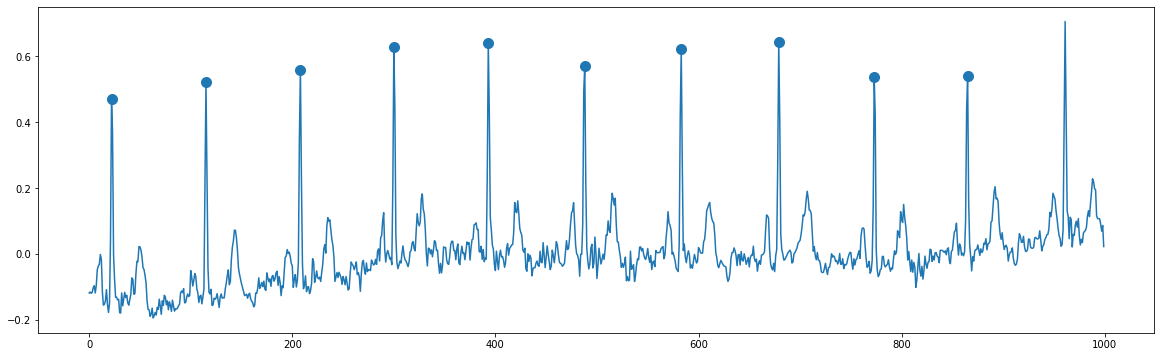

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(ecg_data)
t = np.arange(len(ecg_data))
rpeaks = ecg_info['rpeaks']
plt.scatter(t[rpeaks], ecg_data[rpeaks], s=100)

In [26]:
ecg_info['templates_ts'][-1] - ecg_info['templates_ts'][0]

0.5900000000000001

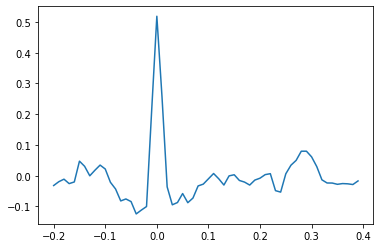

In [30]:
templates_ts = ecg_info['templates_ts']
templates = ecg_info['templates']
plt.plot(templates_ts, templates[1])

In [25]:
np.diff(rpeaks)

array([93, 93, 92, 93, 95, 95, 96, 94, 92])

In [11]:
beats = ecg_sig.get_beats()

In [15]:
beats[0].time

array([0.    , 0.0065, 0.013 , 0.0195, 0.026 , 0.0325, 0.039 , 0.0455,
       0.052 , 0.0585, 0.065 , 0.0715, 0.078 , 0.0845, 0.091 , 0.0975,
       0.104 , 0.1105, 0.117 , 0.1235, 0.13  , 0.1365, 0.143 , 0.1495,
       0.156 , 0.1625, 0.169 , 0.1755, 0.182 , 0.1885, 0.195 , 0.2015,
       0.208 , 0.2145, 0.221 , 0.2275, 0.234 , 0.2405, 0.247 , 0.2535,
       0.26  , 0.2665, 0.273 , 0.2795, 0.286 , 0.2925, 0.299 , 0.3055,
       0.312 , 0.3185, 0.325 , 0.3315, 0.338 , 0.3445, 0.351 , 0.3575,
       0.364 , 0.3705, 0.377 , 0.3835])

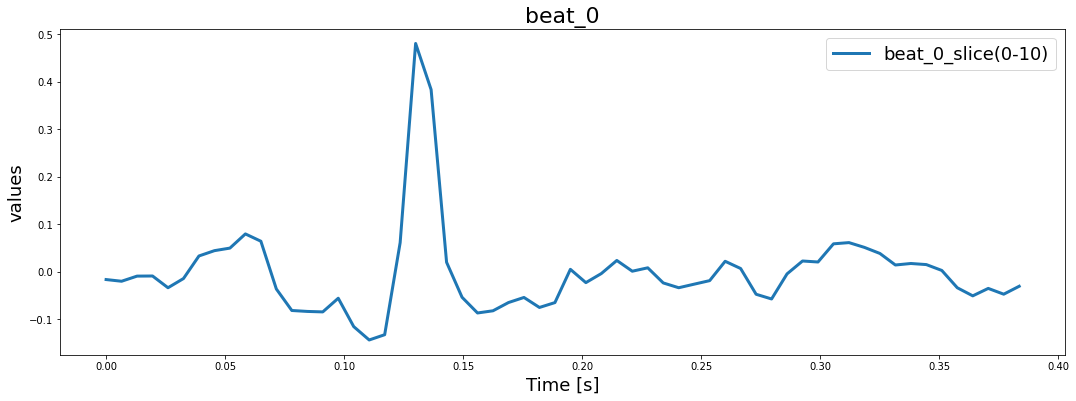

In [14]:
beats[0].plot()

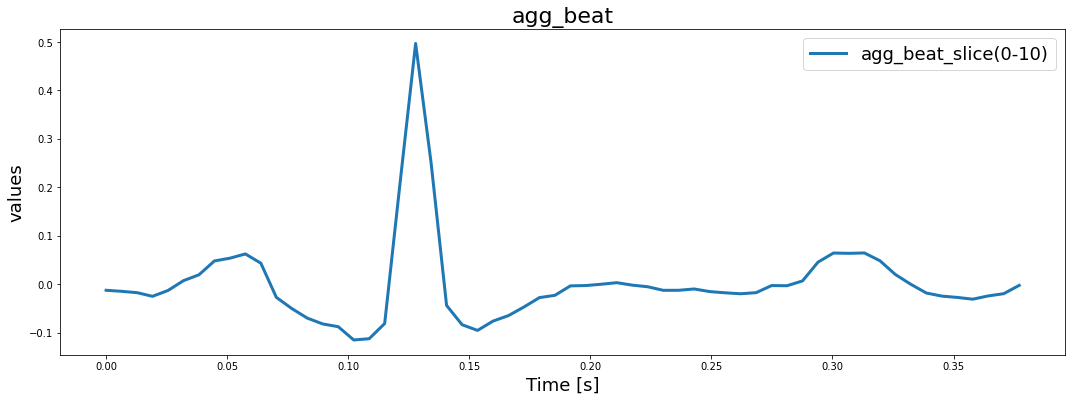

In [13]:
ecg_sig.aggregate(False).plot()

In [45]:
np.diff(ecg_sig.rpeaks) / ecg_sig.fs

array([0.93, 0.93, 0.92, 0.93, 0.95, 0.95, 0.96, 0.94, 0.92])

In [4]:
time = np.array([i for i in range(1000)])/100

In [47]:
ecg_sig.aggregate(False)

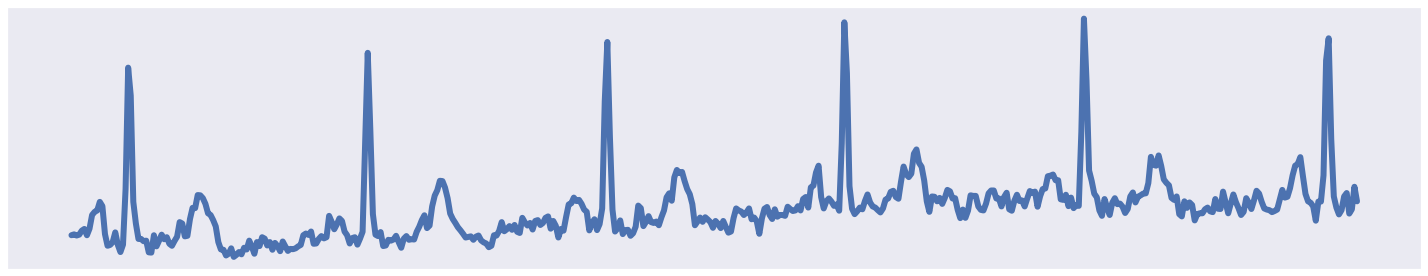

In [6]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=time[:500], y=ptbxl_data['train']['X'][0][:500, 0], lw=6)
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
fig.savefig('presentation_examples/ecg.png', transparent=True)

In [7]:
data_lst = ptbxl_data['train']['X'][:5][:, 0]

In [8]:
from biosppy.signals import ecg, ppg

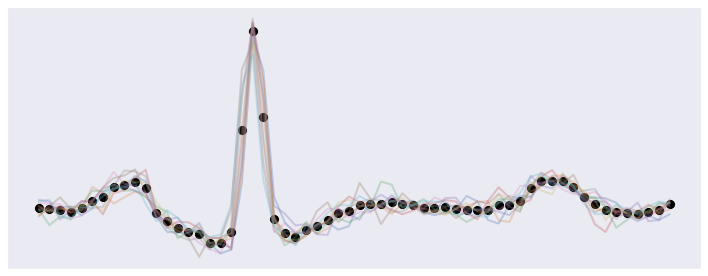

In [9]:
data = ptbxl_data['train']['X'][0][:, 0]
ecg_results = ecg.ecg(data, 100, show=False)
fig, ax = plt.subplots(figsize=(10, 4))

for temp_arr in ecg_results['templates']:
    sns.lineplot(x=ecg_results['templates_ts'], y=temp_arr, lw=2, ax=ax, alpha=0.3)
    
sns.scatterplot(x=ecg_results['templates_ts'], y=ecg_results['templates'].mean(0), s=100, ax=ax, color='black')

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()

fig.savefig('presentation_examples/ecg_segments_scatter.png', transparent=True)

In [10]:
rpeaks_loc = ecg_results['rpeaks']

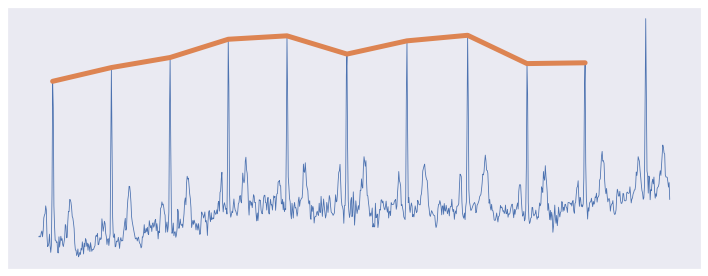

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x=time, y=data, lw=0.8)
sns.lineplot(x=time[rpeaks_loc], y=data[rpeaks_loc], lw=5)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()

fig.savefig('presentation_examples/rpeaks_DC.png', transparent=True)

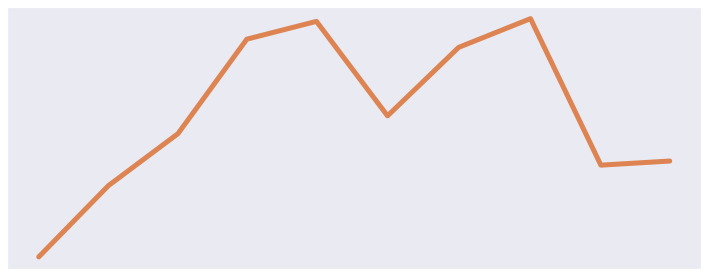

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
# sns.lineplot(x=time, y=data, lw=0.8)
sns.lineplot(x=time[rpeaks_loc], y=data[rpeaks_loc], color=sns.color_palette()[1], lw=5)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()

fig.savefig('presentation_examples/rpeaks_DC_2.png', transparent=True)

<AxesSubplot:>

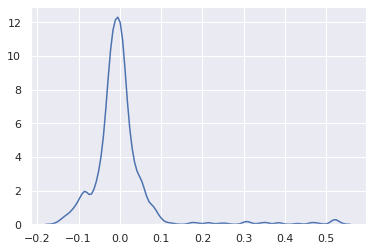

In [151]:
sns.kdeplot(ecg_results['filtered'])

In [100]:
data_lst.shape

(1000, 12)

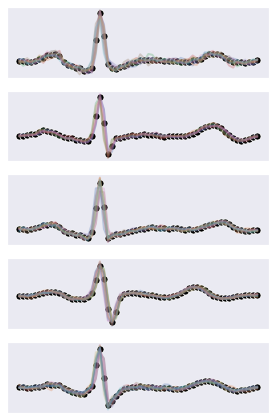

In [107]:
data_lst = ptbxl_data['train']['X'][:5]
# data_lst = ptbxl_data['train']['X'][0]#[:, 0]

fig, axes = plt.subplots(len(data_lst), 1, figsize=(4, 6))

for data, ax in zip(data_lst, axes):
    data = data[:, 0]
    ecg_results = ecg.ecg(data, 100, show=False)
    for temp_arr in ecg_results['templates']:
        sns.lineplot(x=ecg_results['templates_ts'], y=temp_arr, lw=2, ax=ax, alpha=0.3)

    sns.scatterplot(x=ecg_results['templates_ts'], y=ecg_results['templates'].mean(0), s=50, ax=ax, color='black')

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

fig.savefig('presentation_examples/ecg_segments_scatter_5.png', transparent=True)

In [156]:
pd.DataFrame.from_dict({
    ' ': ['sample_1'],
    'R_peak_time': [0.5],
    'R_peak_val': [300],
    'QRS_duration': [0.25],
    'PQ_interval': [0.3],
    '...': ['...']
}).set_index(' ').T

,sample_1
R_peak_time,0.5
R_peak_val,300
QRS_duration,0.25
PQ_interval,0.3
...,...


In [157]:
pd.DataFrame.from_dict({
    ' ': ['sample_1'],
    'kurtosis': [0.5],
    'skewness': [300],
    'mean': [0.25],
    'median': [0.3],
    '...': ['...']
}).set_index(' ').T

,sample_1
kurtosis,0.5
skewness,300
mean,0.25
median,0.3
...,...


In [41]:
pd.DataFrame.from_dict({
    ' ': ['sample_1', '...'],
    'kurtosis': [0.5, '...'],
    'skewness': [300, '...'],
    'mean': [0.25, '...'],
    'median': [0.3, '...'],
    '.': ['...', '...'],
    'most_dominant_frequency': [5, '...'],
    'total_power': [150, '...'],
    'mean_power': [1.5, '...'],
    'mean_frequency': [20, '...'],
    '..': ['...', '...'],
    'R_peak_time': [0.5, '...'],
    'R_peak_val': [300, '...'],
    'QRS_duration': [0.25, '...'],
    'PQ_interval': [0.3, '...'],
    '...': ['...', '...']
}).set_index(' ').T

,sample_1,...
kurtosis,0.5,...
skewness,300,...
mean,0.25,...
median,0.3,...
.,...,...
most_dominant_frequency,5,...
total_power,150,...
mean_power,1.5,...
mean_frequency,20,...
..,...,...


In [33]:
import scipy.fftpack as fftpack

def fft(data, fs, ax=None):
    mags = fftpack.fft(data)
    freqs = fftpack.fftfreq(len(data)) * fs

    ax.stem(freqs, np.abs(mags), use_line_collection=True)
    ax.set_xlabel('Frequency in Hertz [Hz]')
    ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax.set_xlim(-fs/2, fs/2)
    return freqs, mags

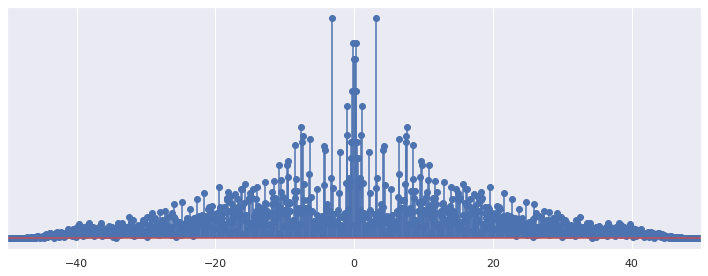

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))

fft(data, 100, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
fig.savefig('presentation_examples/freq_analysis.png', transparent=True)